### Spectroscopic Data Analysis
        Sean Keenan, PhD Physics
        Quantum Memories Group, Heriot-Watt University, Edinburgh
        2021

In [6]:
import spec_funcs as sf
import fit_funcs as ff

##### Set-up script
        Select input folder and polarisation

In [7]:
# change to gui at later date
# polarisations as written in file names
polarisations = ["128", "140", "160", "173"]

# folder containing all the requisite subfolders and data - refrences included
path = "C:\\Users\\sk88\\Desktop\\0222_BB_001"

c_fact = 1

# choose to focus on a particular wavelength range
zoom = False
lower = 580
upper = 650

# mark energies / wavelengths of interest
view = False
woi = [594.24, 603.23, 604.24]

# value to shift each OD
shifter = 0

# save images 
save_fig = False

# reference names
refs = "ref", "reference", "R"

# file extension types
exts = (".csv", ".txt", ".CSV")
exceptions = ("notes", "setup")

##### Import Raw Spectroscopy Data
        Load raw data from csv file (delimiter is not a problem) and sort into groups - polarisations -> reference / spectrum


In [8]:
folder_list, file_list = sf.dir_interogate(path, exts, exceptions)
path_names = sf.read_files(folder_list, file_list)
ref_names, data_names = sf.search_paths(path_names, refs)
ref_data = sf.data_extract(ref_names, polarisations)
data_sets = sf.data_extract(data_names, polarisations)

In [9]:
OD = sf.OD_calc(ref_data, data_sets, correction=True, c_factor=c_fact)

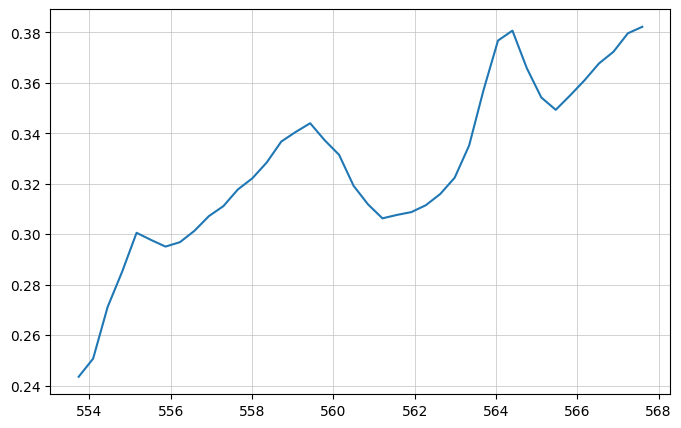

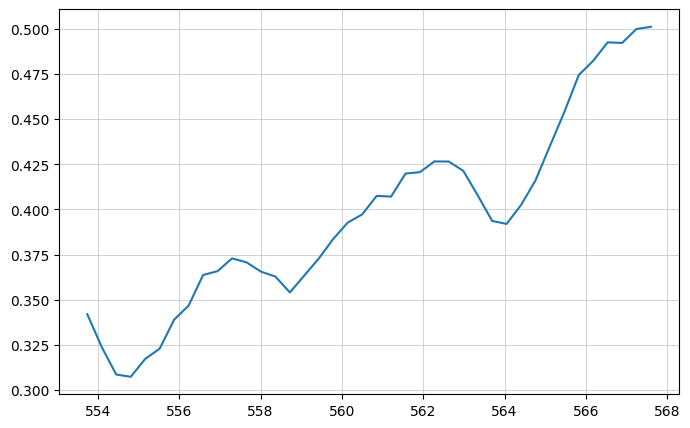

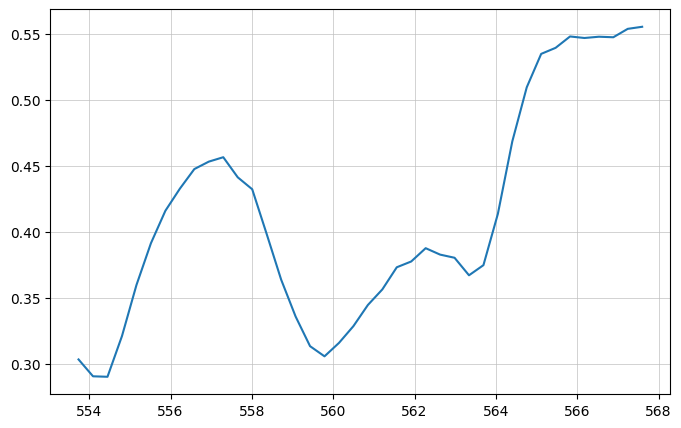

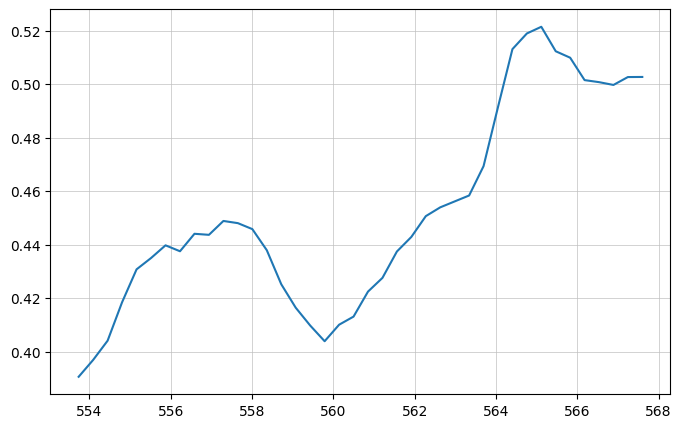

In [12]:
for set in OD:
    for test in set:
        sf.plotter(ref_data[0][0][0], test, lims=(580, 620))

#####  Calculate OD
        Generate interplolated background data to match raw absorption data length and then calculate Optical Depth

In [11]:
'''
Check lengths of arrays and interpolate reference data for each file - avoids issue of wavelength array length mismatch

'''
# cycle through polarisations
for idx_1 in range(len(polarisations)):
    temp_I_0 = []
    temp_OD = []
    I_temp = []
    # generate spline co-effs
    spline_coeffs = si.splrep(bg_wavelengths[idx_1], bg_Is[idx_1])
    # calculate referenece for each wavelength subset
    for idx_2, wavelength in enumerate(wave_sets[idx_1]):
        spline_temp = (si.splev(wavelength, spline_coeffs))
        I_temp = I_sets[idx_1][idx_2]
        # scale data to remove negative values
        if np.nanmin(spline_temp) < 0 or np.nanmin(I_temp) < 0:
            if np.nanmin(spline_temp) < np.nanmin(I_temp):
                adjust = np.nanmin(spline_temp)
            elif np.nanmin(I_temp) < np.nanmin(spline_temp):
                adjust = np.nanmin(I_temp)
            temp_I_0.append(spline_temp - adjust)
            I_temp -= adjust
        else:
            temp_I_0.append(spline_temp)
        temp_OD.append(np.log(temp_I_0[idx_2]/I_temp))
    I_0.append(temp_I_0)
    OD.append(temp_OD)

    # zoom function for wavelength range
if zoom == True:
    for index, waves in enumerate(wave_sets):
        start = []
        stop = []
        for wave in waves:
            for idx, value in enumerate(wave):
                if value <= lower:
                    temp_start = idx
                if value <= upper:
                    temp_stop = idx
            start.append(temp_start)
            stop.append(temp_stop)
        starts.append(start)
        stops.append(stop)
elif zoom != True:
    for index, waves in enumerate(wave_sets):
        start = []
        stop = []
        for wave in waves:
            start.append(0)
            stop.append(-1)
        starts.append(start)
        stops.append(stop)

NameError: name 'si' is not defined

##### Print Raw Output
        Plot individual spectroscopy data

In [ ]:
if zoom == False:
    string_format = path + '\\' + str(round(min(bg_wavelengths[0]))) + '_' + str(round(max(bg_wavelengths[0]))) + '_'
else:
    string_format = path + '\\' + str(lower) + '_' + str(upper) + '_'

# create separate plots for each polarisation
for idx_1, polarisation in enumerate(polarisations):
    
    fig_1, ax_1 = mp.subplots(figsize=(8, 5))
    ax_1.set_title(str('Half-Wave Plate: ' + str(polarisation)))
    ax_1.set(xlabel='Wavelength (nm)', ylabel='OD Normalised')
    sec_ax = ax_1.secondary_xaxis('top', functions= (lambda x: 1e7 / x, lambda x: 1e7 / x))
    sec_ax.set_xlabel('Wavenumber (cm$^{-1}$)')
    ax_1.grid(True)
    ax_1.grid(True, color='silver', linewidth=0.5)
    if view == True:
        for value in woi:
            ax_1.axvline(x=value, linestyle='--')
    
    #shift each spectrum by a defined value
    shift = 0
    for idx_2, wave in enumerate(wave_sets[idx_1]):
        lbl = os.path.split(folder_list[idx_2])
        data = OD[idx_1][idx_2] - np.amin(OD[idx_1][idx_2]) + shift
        ax_1.plot(wave[starts[idx_1][idx_2]:stops[idx_1][idx_2]], data[starts[idx_1][idx_2]:stops[idx_1][idx_2]], color=None, marker=None, linestyle='-', alpha=1, label=lbl[1])
        shift += shifter  
    
    ax_1.legend(loc='upper left', fontsize=8)

    if save_fig == True:
        fig_1.savefig(fname=string_format + str(polarisation) + '.jpg', dpi='figure', format='jpg', bbox_inches='tight')


##### Define ROI and fit to data
        Determine feature profile - Gaussian / Lorentzian and return confidence

In [ ]:
# roi bounds (wavelength)
roi_lower = 590
roi_upper = 610

# select to smooth data
smooth = True
sigma = 0.6

# modifiers for peak finding (prominence, distance between peaks)
prom_tol = 0.1
dist = 10

# array to identify indexes for roi
roi_waves = []
roi_ODs = []
peaks = []
smoothed = []
smoothed_peaks = []
for index, waves in enumerate(wave_sets):
    roi_wave_temp = []
    roi_OD_temp = []
    temp_peaks = []
    for index_2, wave in enumerate(waves):
        for idx, value in enumerate(wave):
            if value <= roi_lower:
                temp_start = idx
            if value <= roi_upper:
                temp_stop = idx
        roi_wave_temp.append(np.array(wave[temp_start:temp_stop]))
        roi_OD_temp.append(OD[index][index_2][temp_start:temp_stop])
        peak, _ = ss.find_peaks(roi_OD_temp[index_2], distance=dist, prominence=np.amax(roi_OD_temp[index_2]) * prom_tol)
        temp_peaks.append(peak)
        if smooth == True:
            smoothed_temp = []
            smoothed_peaks_temp = []
            smoothed_temp.append(nd.gaussian_filter(roi_OD_temp[index_2], sigma))
            smoothed_peaks_temp.append(ss.find_peaks(smoothed_temp[index_2], distance=dist, prominence=np.amax(smoothed_temp[index_2]) * prom_tol))
    roi_waves.append(roi_wave_temp)
    roi_ODs.append(roi_OD_temp)
    peaks.append(temp_peaks)
    smoothed.append(smoothed_temp)
    smoothed_peaks.append(smoothed_peaks_temp)

if smooth == True:
    gauss_ODs = [nd.gaussian_filter(x, sigma) for x in roi_ODs]

for idx_1, polarisation in enumerate(polarisations):

    fig_2, ax_2 = mp.subplots(figsize=(8, 5))
    ax_2.set_title(str('Half-Wave Plate: ' + str(polarisation)))
    ax_2.set(xlabel='Wavelength (nm)', ylabel='OD Normalised')
    sec_ax = ax_2.secondary_xaxis('top', functions= (lambda x: 1e7 / x, lambda x: 1e7 / x))
    sec_ax.set_xlabel('Wavenumber (cm$^{-1}$)')
    ax_2.grid(True)
    ax_2.grid(True, color='silver', linewidth=0.5)
    
    for idx_2, data in enumerate(roi_waves[idx_1]):
        ax_2.plot(data, roi_ODs[idx_1][idx_2])
        ax_2.plot(data[peaks[idx_1][idx_2]], roi_ODs[idx_1][idx_2][peaks[idx_1][idx_2]], 'bx')
        if smooth == True:
            ax_2.plot(data, smoothed[idx_1][idx_2], '--r')
        print('peak locations for Half-Wave Plate: ' + str(polarisation), peaks[idx_1][idx_2])

In [ ]:
diff = np.diff(roi_ODs[4][0], n=1)
diff_2 = np.diff(roi_ODs[4][0], n=2)
diff_3 = np.diff(roi_ODs[4][0], n=3)

mp.plot(diff)
#mp.plot(diff_2)
#mp.plot(diff_3)
mp.plot(roi_ODs[4][0])

In [ ]:
x =np.linspace(-100, 100, 10000)
amp_g = 40
amp_l = 20
y_0 = 0
x_0g = 1
x_0l = -1
sigma = 15
gamma = 40
eta = 0.8

gauss = sf.gaussian(x, amp_g, y_0, x_0g, sigma)
lorentz = sf.lorentzian(x, amp_l, y_0, x_0l, gamma)
noise = np.random.normal(size=np.size(gauss))

voigt = sf.pseudo_voigt(x, y_0, amp_g, x_0g, sigma, amp_l, x_0l, gamma, eta) + noise

mp.plot(x, gauss, 'r', label='gauss')
mp.plot(x, lorentz, 'b', label='lorentz')
mp.plot(x, voigt, 'orange', alpha=0.5, label='voigt')
mp.legend()

In [ ]:
fit_g = sf.fitgauss(x, voigt)
fit_l = sf.fitlorentz(x, voigt)
fit_v = sf.fitgls(x, voigt)

mp.plot(x, sf.lorentzian(x, *fit_l[0]), '--b', label='lorentz fit')
mp.plot(x, sf.gaussian(x, *fit_g[0]), '--g', label='gauss fit')
mp.plot(x, sf.pseudo_voigt(x, *fit_v[0]), '--r', label='voigt fit')
mp.plot(x, voigt, color='orange', alpha=0.5, label='noisey voigt')
mp.legend()